In [1]:
# imports
import time
import datetime
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import geopandas as gp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [40, 20]
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

first_datetime = datetime.datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
last_datetime = datetime.datetime.strptime('2018-02-01 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-07-01 00:00:00'
train_valid_split_datetime = datetime.datetime.strptime('2018-01-29 00:00:00', '%Y-%m-%d %H:%M:%S')  # '2018-06-01 00:00:00'
print('first_datetime:', first_datetime)
print('last_datetime:', last_datetime)
print('train_valid_split_datetime:', train_valid_split_datetime)

first_datetime: 2018-01-01 00:00:00
last_datetime: 2018-02-01 00:00:00
train_valid_split_datetime: 2018-01-29 00:00:00


In [2]:
taxi_zone_lookup = pd.read_csv('nyc-tlc/misc/taxi _zone_lookup.csv')
print('taxi_zone_lookup:', taxi_zone_lookup.shape)
manhattan_location_ids = taxi_zone_lookup[taxi_zone_lookup['Borough']=='Manhattan']['LocationID'].values
print('manhattan_location_ids:', manhattan_location_ids.shape)
manhattan_location_ids

taxi_zone_lookup: (265, 4)
manhattan_location_ids: (69,)


array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 103, 104, 105, 107, 113, 114, 116, 120,
       125, 127, 128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153,
       158, 161, 162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224,
       229, 230, 231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246,
       249, 261, 262, 263])

In [3]:
taxi_zone_lookup.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [4]:
def get_5min_id(x):
    return (x-first_datetime).total_seconds()//(5*60)

def get_15min_id(x):
    return (x-first_datetime).total_seconds()//(15*60)

def get_30min_id(x):
    return (x-first_datetime).total_seconds()//(30*60)

In [5]:
train_valid_split_5min_id = get_5min_id(train_valid_split_datetime)
train_valid_split_15min_id = get_15min_id(train_valid_split_datetime)
train_valid_split_30min_id = get_30min_id(train_valid_split_datetime)
print('train_valid_split_5min_id:', train_valid_split_5min_id)
print('train_valid_split_15min_id:', train_valid_split_15min_id)
print('train_valid_split_30min_id:', train_valid_split_30min_id)

train_valid_split_5min_id: 8064.0
train_valid_split_15min_id: 2688.0
train_valid_split_30min_id: 1344.0


In [6]:
def filter_abnormal_data(sample):
    start = time.time()
    sample_manhattan = sample[sample['PULocationID'].isin(manhattan_location_ids)].copy()
    print('filter PULocationID:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['tpep_pickup_datetime'] = pd.to_datetime(sample_manhattan['tpep_pickup_datetime'])
    print('tpep_pickup_datetime:', time.time()-start)
    sample_manhattan['tpep_dropoff_datetime'] = pd.to_datetime(sample_manhattan['tpep_dropoff_datetime'])
    print('tpep_dropoff_datetime:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] > 0]
    print('filter trip_distance:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_duration'] = (sample_manhattan['tpep_dropoff_datetime']-sample_manhattan['tpep_pickup_datetime']).dt.total_seconds()
    print('trip_duration:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] > 0]
    print('filter trip_duration:', sample_manhattan.shape, time.time()-start)
    sample_manhattan['trip_speed'] = sample_manhattan['trip_distance']/sample_manhattan['trip_duration']*3600
    print('trip_speed:', time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] > 0]
    sample_manhattan = sample_manhattan[sample_manhattan['trip_speed'] <= 200]
    print('filter trip_speed:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] > 0]
    print('filter total_amount:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] >= first_datetime]
    print('filter tpep_pickup_datetime first_datetime:', sample_manhattan.shape, time.time()-start)
    sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] < last_datetime]
    print('filter tpep_pickup_datetime last_datetime:', sample_manhattan.shape, time.time()-start)
    return sample_manhattan

In [7]:
demo = False
if demo:
    sample = pd.read_csv('nyc-tlc/trip data/sample.csv')
    sample_manhattan = filter_abnormal_data(sample)
else:
    for m in range(1, 2):  # (1, 7)
        start = time.time()
        sample_1 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-0' + str(m) + '.csv')
        print('read_csv 2018-0'+str(m)+':', time.time()-start)
        sample_1 = filter_abnormal_data(sample_1)
        print('filter_abnormal_data:', time.time()-start)
        if m == 1:
            sample_manhattan = sample_1
        else:
            sample_manhattan = pd.concat([sample_manhattan, sample_1], axis=0)
        print('concat:', time.time()-start)
print('sample_manhattan:', sample_manhattan.shape)

start = time.time()

m = np.mean(sample_manhattan['total_amount'])
s = np.std(sample_manhattan['total_amount'])
print('total_amount m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] <= m + 10*s]
#sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] >= m - 10*s]
print('filter total_amount:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_distance'])
s = np.std(sample_manhattan['trip_distance'])
print('trip_distance m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] <= m + 20*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_distance'] >= m - 20*s]
print('filter trip_distance:', sample_manhattan.shape, time.time()-start)

m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
print('trip_duration m:', m, 's:', s)
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
#sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', sample_manhattan.shape, time.time()-start)

print('sample_manhattan.shape:', sample_manhattan.shape)

read_csv 2018-01: 22.178088188171387
filter PULocationID: (7965703, 17) 2.0981991291046143
tpep_pickup_datetime: 4.150105714797974
tpep_dropoff_datetime: 6.1768834590911865
filter trip_distance: (7935134, 17) 6.8687684535980225
trip_duration: 8.07521104812622
filter trip_duration: (7935017, 18) 9.182518482208252
trip_speed: 9.280439615249634
filter trip_speed: (7931840, 19) 11.032450914382935
filter total_amount: (7928802, 19) 11.633007526397705
filter tpep_pickup_datetime first_datetime: (7928569, 19) 12.265905618667603
filter tpep_pickup_datetime last_datetime: (7928497, 19) 12.879138231277466
filter_abnormal_data: 35.2734854221344
concat: 35.273605823516846
sample_manhattan: (7928497, 19)
total_amount m: 13.526606089401307 s: 9.692531310002575
filter total_amount: (7925658, 19) 0.6306982040405273
trip_distance m: 2.233562362897817 s: 2.4878265305725793
filter trip_distance: (7925654, 19) 1.360154628753662
trip_duration m: 870.7019522931483 s: 3550.1005807871866
filter trip_duration:

In [8]:
start = time.time()
#sample_manhattan['tpep_pickup_date'] = sample_manhattan['tpep_pickup_datetime'].dt.date
#print('tpep_pickup_date:', time.time()-start)
#sample_manhattan['tpep_dropoff_date'] = sample_manhattan['tpep_dropoff_datetime'].dt.date
#print('tpep_dropoff_date:', time.time()-start)
sample_manhattan['tpep_pickup_year'] = sample_manhattan['tpep_pickup_datetime'].dt.year
print('tpep_pickup_year:', time.time()-start)
sample_manhattan['tpep_pickup_month'] = sample_manhattan['tpep_pickup_datetime'].dt.month
print('tpep_pickup_month:', time.time()-start)
sample_manhattan['tpep_pickup_day'] = sample_manhattan['tpep_pickup_datetime'].dt.day
print('tpep_pickup_day:', time.time()-start)
sample_manhattan['tpep_pickup_hour'] = sample_manhattan['tpep_pickup_datetime'].dt.hour
print('tpep_pickup_hour:', time.time()-start)
sample_manhattan['tpep_pickup_weekday'] = sample_manhattan['tpep_pickup_datetime'].dt.weekday
print('tpep_pickup_weekday:', time.time()-start)
sample_manhattan['is_weekend'] = sample_manhattan['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
print('is_weekend:', time.time()-start)
sample_manhattan['is_morning_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
print('is_morning_peak:', time.time()-start)
sample_manhattan['is_evening_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
print('is_evening_peak:', time.time()-start)
sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x == 'N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)

#store_and_fwd_flag_dummy = pd.get_dummies(sample_manhattan['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
#print('store_and_fwd_flag_dummy:', time.time()-start)
#passenger_count_dummy = pd.get_dummies(sample_manhattan['passenger_count'], prefix='pc', prefix_sep='_')
#print('passenger_count_dummy:', time.time()-start)
#RatecodeID_dummy = pd.get_dummies(sample_manhattan['RatecodeID'], prefix='rc', prefix_sep='_')
#print('RatecodeID_dummy:', time.time()-start)
#payment_type_dummy = pd.get_dummies(sample_manhattan['payment_type'], prefix='pt', prefix_sep='_')
#print('payment_type_dummy:', time.time()-start)

#sample_manhattan = pd.concat([sample_manhattan, store_and_fwd_flag_dummy, passenger_count_dummy, RatecodeID_dummy, payment_type_dummy], axis=1)  # TODO memory error
#print('concat:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(5*60)
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(15*60)
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = (sample_manhattan['tpep_pickup_datetime']-first_datetime).dt.total_seconds()//(30*60)
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime'], axis=1, inplace=True)  # , 'tpep_pickup_date', 'tpep_dropoff_date'

tpep_pickup_year: 0.3699612617492676
tpep_pickup_month: 0.7048482894897461
tpep_pickup_day: 1.046238660812378
tpep_pickup_hour: 1.391477108001709
tpep_pickup_weekday: 1.7942540645599365
is_weekend: 4.758326530456543
is_morning_peak: 7.916479110717773
is_evening_peak: 11.038670778274536
store_and_fwd_flag: 14.349606275558472
tpep_pickup_5min_id: 15.56901240348816
tpep_pickup_15min_id: 16.00973391532898
tpep_pickup_30min_id: 16.461307525634766


In [9]:
sample_manhattan.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,1,0.500,1,1,41,24,2,4.500,0.500,0.500,0.000,0.000,0.300,5.800,198.000,9.091,2018,1,1,0,0,0,0,0,4.000,1.000,0.000
1,1,1,2.700,1,1,239,140,2,14.000,0.500,0.500,0.000,0.000,0.300,15.300,1090.000,8.917,2018,1,1,0,0,0,0,0,8.000,2.000,1.000
2,1,2,0.800,1,1,262,141,1,6.000,0.500,0.500,1.000,0.000,0.300,8.300,355.000,8.113,2018,1,1,0,0,0,0,0,1.000,0.000,0.000
3,1,1,10.200,1,1,140,257,2,33.500,0.500,0.500,0.000,0.000,0.300,34.800,1949.000,18.840,2018,1,1,0,0,0,0,0,4.000,1.000,0.000
4,1,2,2.500,1,1,246,239,1,12.500,0.500,0.500,2.750,0.000,0.300,16.550,1068.000,8.427,2018,1,1,0,0,0,0,0,1.000,0.000,0.000


In [10]:
sample_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
count,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000,7911277.000
mean,1.563,1.610,2.232,1.013,1.000,165.066,162.319,1.305,10.646,0.319,0.499,1.579,0.131,0.300,13.477,722.656,10.756,2018.000,1.000,16.733,13.725,2.853,0.257,0.136,0.188,4701.323,1566.774,783.137
std,0.496,1.261,2.484,0.171,0.000,66.235,69.048,0.474,7.540,0.402,0.023,1.832,0.994,0.003,9.316,511.095,5.269,0.000,0.000,8.708,6.041,1.957,0.437,0.342,0.391,2510.091,836.697,418.349
min,1.000,0.000,0.010,1.000,1.000,4.000,1.000,1.000,0.000,-0.500,0.000,0.000,0.000,0.000,0.300,1.000,0.005,2018.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,0.900,1.000,1.000,114.000,113.000,1.000,6.000,0.000,0.500,0.000,0.000,0.300,8.160,368.000,7.385,2018.000,1.000,10.000,9.000,1.000,0.000,0.000,0.000,2683.000,894.000,447.000
50%,2.000,1.000,1.490,1.000,1.000,162.000,162.000,1.000,8.500,0.000,0.500,1.360,0.000,0.300,11.000,597.000,9.704,2018.000,1.000,17.000,14.000,3.000,0.000,0.000,0.000,4789.000,1596.000,798.000
75%,2.000,2.000,2.500,1.000,1.000,234.000,234.000,2.000,12.500,0.500,0.500,2.200,0.000,0.300,15.360,938.000,12.813,2018.000,1.000,24.000,19.000,5.000,1.000,0.000,0.000,6878.000,2292.000,1146.000
max,2.000,9.000,51.900,99.000,1.000,263.000,265.000,4.000,110.000,60.000,0.500,100.510,95.750,0.300,110.400,7966.000,200.000,2018.000,1.000,31.000,23.000,6.000,1.000,1.000,1.000,8927.000,2975.000,1487.000


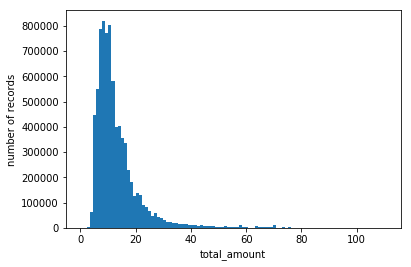

In [11]:
plt.hist(sample_manhattan['total_amount'].values, bins=100)
plt.xlabel('total_amount')
plt.ylabel('number of records')
plt.show()

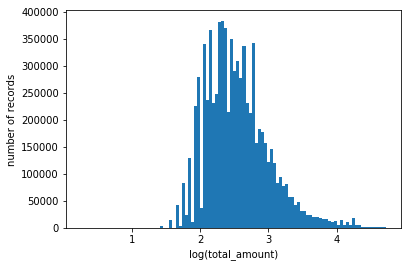

In [12]:
sample_manhattan['log_total_amount'] = np.log(sample_manhattan['total_amount'].values + 1)
plt.hist(sample_manhattan['log_total_amount'].values, bins=100)
plt.xlabel('log(total_amount)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

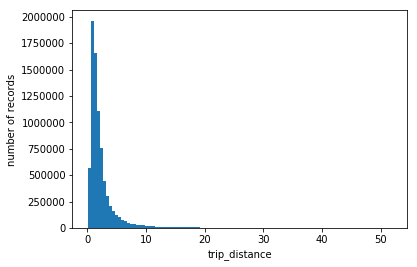

In [13]:
plt.hist(sample_manhattan['trip_distance'].values, bins=100)
plt.xlabel('trip_distance')
plt.ylabel('number of records')
plt.show()

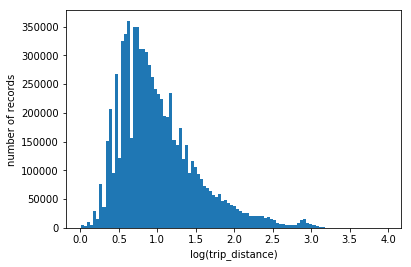

In [14]:
sample_manhattan['log_trip_distance'] = np.log(sample_manhattan['trip_distance'].values + 1)
plt.hist(sample_manhattan['log_trip_distance'].values, bins=100)
plt.xlabel('log(trip_distance)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

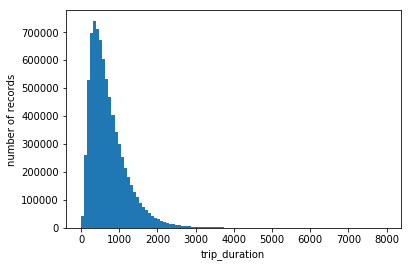

In [15]:
plt.hist(sample_manhattan['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of records')
plt.show()

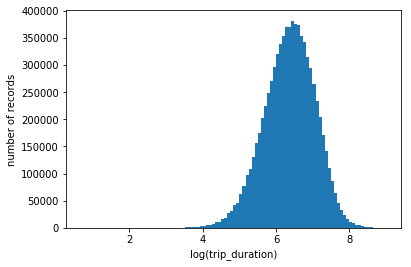

In [16]:
sample_manhattan['log_trip_duration'] = np.log(sample_manhattan['trip_duration'].values + 1)
plt.hist(sample_manhattan['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

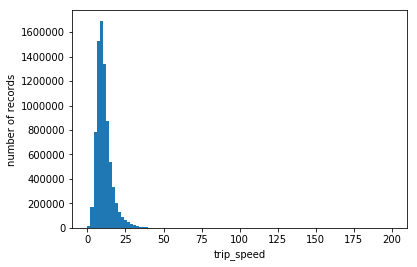

In [17]:
plt.hist(sample_manhattan['trip_speed'].values, bins=100)
plt.xlabel('trip_speed')
plt.ylabel('number of records')
plt.show()

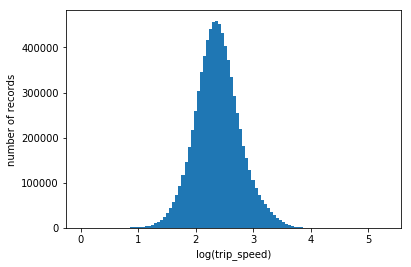

In [18]:
sample_manhattan['log_trip_speed'] = np.log(sample_manhattan['trip_speed'].values + 1)
plt.hist(sample_manhattan['log_trip_speed'].values, bins=100)
plt.xlabel('log(trip_speed)')
plt.ylabel('number of records')
plt.show()
#sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

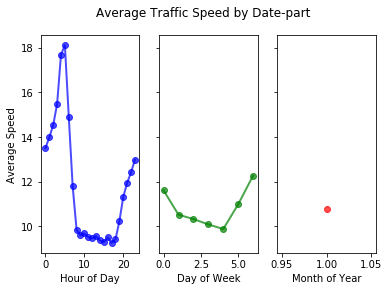

In [19]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(sample_manhattan.groupby('tpep_pickup_hour').mean()['trip_speed'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(sample_manhattan.groupby('tpep_pickup_weekday').mean()['trip_speed'], 'go-', lw=2, alpha=0.7)
ax[2].plot(sample_manhattan.groupby('tpep_pickup_month').mean()['trip_speed'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

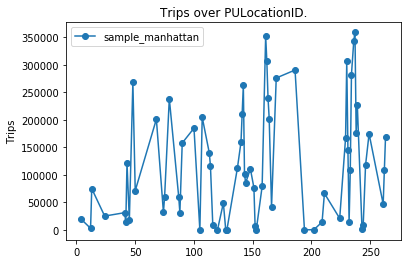

In [20]:
plt.plot(sample_manhattan.groupby(['PULocationID']).count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over PULocationID.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

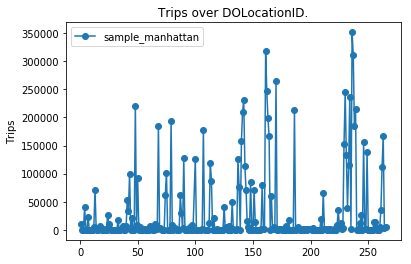

In [21]:
plt.plot(sample_manhattan.groupby(['DOLocationID']).count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over DOLocationID.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

In [22]:
taxi_zones_shape = gp.GeoDataFrame.from_file('nyc-tlc/misc/taxi_zones/taxi_zones.shp')
taxi_zones_shape = taxi_zones_shape[taxi_zones_shape['borough'] == 'Manhattan']
#taxi_zones_shape['color'] = 'green'
taxi_zones_shape.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ..."
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,..."
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,..."
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,..."


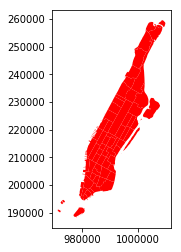

In [23]:
taxi_zones_shape.plot(color='red')

In [24]:
PULocationID_group = sample_manhattan.groupby(['PULocationID']).count()[['VendorID']]
PULocationID_group['VendorID'] = PULocationID_group['VendorID']/sample_manhattan.shape[0]*100
PULocationID_group.head()

,VendorID
PULocationID,
4,0.246
12,0.037
13,0.949
24,0.318
41,0.396


In [25]:
taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
taxi_zones_shape_requests.fillna(0, inplace=True)
taxi_zones_shape_requests.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,VendorID
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,...",0.246
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ...",0.037
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,...",0.949
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,...",0.318
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,...",0.396


taxi_zones_shape_requests: <class 'geopandas.geodataframe.GeoDataFrame'>


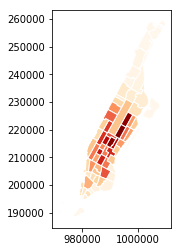

In [26]:
print('taxi_zones_shape_requests:', type(taxi_zones_shape_requests))
taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')

In [27]:
#for group_name, group_data in sample_manhattan.groupby(['tpep_pickup_5min_id']):
#    #print('group_name:', group_name)
#    #print(group_data.head())
#    PULocationID_group = group_data.groupby(['PULocationID']).count()[['VendorID']]
#    PULocationID_group['VendorID'] = PULocationID_group['VendorID']/sample_manhattan.shape[0]*100
#    #PULocationID_group.head()
#    taxi_zones_shape_requests = taxi_zones_shape.join(PULocationID_group, on=['LocationID'], how='left')
#    taxi_zones_shape_requests.fillna(0, inplace=True)
#    #taxi_zones_shape_requests.head()
#    #print('taxi_zones_shape_requests:', type(taxi_zones_shape_requests))
#    fig = taxi_zones_shape_requests.plot(column='VendorID', cmap='OrRd', edgecolor='white')
#    fig.get_figure().savefig('images/'+str(group_name)+'.png')

In [28]:
train_sample_5min_count = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] < train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
print('train_sample_5min_count:', train_sample_5min_count.shape)
valid_sample_5min_count = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] >= train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
print('valid_sample_5min_count:', valid_sample_5min_count.shape)

train_sample_5min_count: (430343,)
valid_sample_5min_count: (45501,)


In [29]:
train_sample_5min_count.head()

tpep_pickup_5min_id  PULocationID
0.000                4               3
                     13              4
                     24              2
                     41              3
                     42              3
Name: VendorID, dtype: int64

In [30]:
valid_sample_5min_count.head()

tpep_pickup_5min_id  PULocationID
8064.000             4               2
                     12              1
                     13              1
                     24              1
                     41              1
Name: VendorID, dtype: int64

In [ ]:
sample_manhattan_5min_pickup_count = sample_manhattan.groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
sample_manhattan_5min_dropoff_count = sample_manhattan.groupby(['tpep_pickup_5min_id', 'DOLocationID']).count()['VendorID']

In [31]:
def generate_features(data_X):
    start = time.time()
    ago_5min = []
    ago_5min_drop = []
    ago_1day_now = []
    ago_7day_now = []
    ago_14day_now = []
    ago_21day_now = []
    ago_28day_now = []
    for index,row in data_X.iterrows():
        #print('index:', index)
        #print('row:', row)
        try:
            ago_5min.append(sample_manhattan_5min_pickup_count[index[0]-1][index[1]])
        except:
            ago_5min.append(0)
        try:
            ago_5min_drop.append(sample_manhattan_5min_dropoff_count[index[0]-1][index[1]])
        except:
            ago_5min_drop.append(0)
        try:
            ago_1day_now.append(sample_manhattan_5min_pickup_count[index[0]-288][index[1]])
        except:
            ago_1day_now.append(0)
        try:
            ago_7day_now.append(sample_manhattan_5min_pickup_count[index[0]-288*7][index[1]])
        except:
            ago_7day_now.append(0)
        try:
            ago_14day_now.append(sample_manhattan_5min_pickup_count[index[0]-288*14][index[1]])
        except:
            ago_14day_now.append(0)
        try:
            ago_21day_now.append(sample_manhattan_5min_pickup_count[index[0]-288*21][index[1]])
        except:
            ago_21day_now.append(0)
        try:
            ago_28day_now.append(sample_manhattan_5min_pickup_count[index[0]-288*28][index[1]])
        except:
            ago_28day_now.append(0)
    data_X['5min_ago'] = np.array(ago_5min)
    data_X['5min_ago_drop'] = np.array(ago_5min_drop)
    data_X['1day_ago_now'] = np.array(ago_1day_now)
    data_X['7day_ago_now'] = np.array(ago_7day_now)
    data_X['14day_ago_now'] = np.array(ago_14day_now)
    data_X['21day_ago_now'] = np.array(ago_21day_now)
    data_X['28day_ago_now'] = np.array(ago_28day_now)
    print('data_X time:', time.time()-start)
    return data_X

In [35]:
train_X = pd.DataFrame(train_sample_5min_count)
print(train_X.index.shape)
train_X = generate_features(train_X)
print('train_X:', train_X.shape)
valid_X = pd.DataFrame(valid_sample_5min_count)
valid_X = generate_features(valid_X)
print('valid_X:', valid_X.shape)
train_Y = train_sample_5min_count.values
print('train_Y:', len(train_Y))
valid_Y = valid_sample_5min_count.values
print('valid_Y:', len(valid_Y))

(430343,)
data_X time: 712.2361762523651
train_X: (430343, 7)
data_X time: 109.88853764533997
valid_X: (45501, 7)
train_Y: 430343
valid_Y: 45501


In [36]:
train_X.head()

VendorID  5min_ago  1day_ago_now  \
tpep_pickup_5min_id PULocationID                                     
0.000               4                    3         0             0   
                    13                   4         0             0   
                    24                   2         0             0   
                    41                   3         0             0   
                    42                   3         0             0   

                                  7day_ago_now  14day_ago_now  21day_ago_now  \
tpep_pickup_5min_id PULocationID                                               
0.000               4                        0              0              0   
                    13                       0              0              0   
                    24                       0              0              0   
                    41                       0              0              0   
                    42                       0              0              0   

                                  28day_ago_now  
tpep_pickup_5min_id PULocationID                 
0.000               4                         0  
                    13                        0  
                    24                        0  
                    41                        0  
                    42                        0

In [37]:
valid_X.head()

VendorID  5min_ago  1day_ago_now  \
tpep_pickup_5min_id PULocationID                                     
8064.000            4                    2         1            10   
                    12                   1         0             0   
                    13                   1         1             2   
                    24                   1         0             1   
                    41                   1         1             3   

                                  7day_ago_now  14day_ago_now  21day_ago_now  \
tpep_pickup_5min_id PULocationID                                               
8064.000            4                        0              4              1   
                    12                       1              0              0   
                    13                       1              3              2   
                    24                       1              3              2   
                    41                       0              6              1   

                                  28day_ago_now  
tpep_pickup_5min_id PULocationID                 
8064.000            4                         3  
                    12                        0  
                    13                        4  
                    24                        2  
                    41                        3

In [38]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('VendorID', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('VendorID', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    # param['eta'] = 0.02
    param['max_depth'] = 20  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    # num_round = 5
    num_round = 400

    # param['objective'] = 'reg:linear'
    param['objective'] = 'reg:gamma'
    bst = xgb.train(param, xg_train, num_round, watchlist)

    # xgb.plot_tree(bst)
    # plt.savefig('xgboost_tree.png')
    # xgb.plot_importance(bst)
    # plt.savefig('xgboost_importance.png')
    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))

In [39]:
xgb_train_validate(train_X, train_Y, valid_X, valid_Y)

[0]	train-mae:15.957	test-mae:17.2219
[1]	train-mae:15.9049	test-mae:17.1697
[2]	train-mae:15.8473	test-mae:17.1127
[3]	train-mae:15.7859	test-mae:17.0511
[4]	train-mae:15.7194	test-mae:16.9842
[5]	train-mae:15.6475	test-mae:16.9118
[6]	train-mae:15.5697	test-mae:16.8335
[7]	train-mae:15.4858	test-mae:16.749
[8]	train-mae:15.3972	test-mae:16.6597
[9]	train-mae:15.303	test-mae:16.5658
[10]	train-mae:15.2068	test-mae:16.4679
[11]	train-mae:15.1046	test-mae:16.3641
[12]	train-mae:14.9959	test-mae:16.2537
[13]	train-mae:14.879	test-mae:16.1351
[14]	train-mae:14.7534	test-mae:16.0073
[15]	train-mae:14.6186	test-mae:15.8701
[16]	train-mae:14.4749	test-mae:15.7241
[17]	train-mae:14.3225	test-mae:15.5678
[18]	train-mae:14.1607	test-mae:15.4017
[19]	train-mae:13.989	test-mae:15.225
[20]	train-mae:13.8074	test-mae:15.0378
[21]	train-mae:13.6158	test-mae:14.8393
[22]	train-mae:13.4134	test-mae:14.6305
[23]	train-mae:13.2009	test-mae:14.4099
[24]	train-mae:12.9805	test-mae:14.1794
[25]	train-mae:1

[204]	train-mae:3.50081	test-mae:3.52033
[205]	train-mae:3.50049	test-mae:3.52035
[206]	train-mae:3.5005	test-mae:3.52035
[207]	train-mae:3.50042	test-mae:3.52039
[208]	train-mae:3.50033	test-mae:3.52042
[209]	train-mae:3.5002	test-mae:3.52042
[210]	train-mae:3.50007	test-mae:3.52013
[211]	train-mae:3.50007	test-mae:3.52013
[212]	train-mae:3.49992	test-mae:3.52046
[213]	train-mae:3.49976	test-mae:3.52062
[214]	train-mae:3.49967	test-mae:3.52033
[215]	train-mae:3.49967	test-mae:3.52041
[216]	train-mae:3.4996	test-mae:3.52057
[217]	train-mae:3.49952	test-mae:3.52123
[218]	train-mae:3.4995	test-mae:3.52122
[219]	train-mae:3.49948	test-mae:3.52127
[220]	train-mae:3.49931	test-mae:3.52101
[221]	train-mae:3.49926	test-mae:3.52099
[222]	train-mae:3.49912	test-mae:3.52105
[223]	train-mae:3.49907	test-mae:3.5211
[224]	train-mae:3.49903	test-mae:3.52065
[225]	train-mae:3.49898	test-mae:3.5207
[226]	train-mae:3.49877	test-mae:3.5206
[227]	train-mae:3.49862	test-mae:3.52065
[228]	train-mae:3.49862

In [40]:
train_X.describe()

,VendorID,5min_ago,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,430343.000,430343.000,430343.000,430343.000,430343.000,430343.000,430343.000
mean,16.505,16.397,15.801,11.957,7.682,3.359,0.000
std,17.274,17.369,17.410,16.248,13.921,9.356,0.000
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3.000,3.000,3.000,0.000,0.000,0.000,0.000
50%,10.000,10.000,10.000,5.000,0.000,0.000,0.000
75%,24.000,24.000,24.000,18.000,10.000,0.000,0.000
max,173.000,173.000,157.000,157.000,150.000,128.000,0.000


In [41]:
valid_X.describe()

,VendorID,5min_ago,1day_ago_now,7day_ago_now,14day_ago_now,21day_ago_now,28day_ago_now
count,45501.000,45501.000,45501.000,45501.000,45501.000,45501.000,45501.000
mean,17.770,17.658,16.292,17.192,16.676,16.319,14.069
std,18.878,18.972,17.468,18.606,17.825,17.289,15.069
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,4.000,3.000,3.000,3.000,3.000,3.000,3.000
50%,11.000,11.000,11.000,11.000,10.000,10.000,9.000
75%,26.000,26.000,24.000,25.000,25.000,24.000,21.000
max,135.000,135.000,173.000,148.000,137.000,129.000,128.000
